# Objective: Solve u_t + (u(1-u))_x = 0 for x,t \in [0,1]x[0,tmax] using PINN. use initial condition u_0= 0.5 +0.3cos(2*pi*x) and BC's u(0,t) = u(1,t); u_x(0,t)=u_x(1,t)

## We will enforce u_t + (u(1-u))_x = 0 at grid points (x_i,t_i).

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io

In [76]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [77]:
# Hyper-parameters 
input_size = 2 # (x,t)
hidden_size = 20 #number of neurons in each hidden layer
n_layers = 20  #number of hidden layers
output_size = 1
num_epochs = 2000
learning_rate = 0.001
tmax=0.5  #the maximum time forward which we predict , at the end we want tmax=5.
dx = 0.01
N = int(1/dx) # have N+1 space steps, 0,...,N
dt = dx/10 # to satisfy CFL condition
M = int(tmax/dt) # number of time steps
print(f'Using {N} spacial grid points,  {M} time steps')

Using 100 spacial grid points,  500 time steps


In [78]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        
        # Define the input layer with 2 inputs
        self.input_layer = nn.Linear(input_size, hidden_size)
        
        # Define 10 hidden layers with tanh activation function
        self.hidden_layers = nn.ModuleList([
            nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.Tanh())
            for _ in range(n_layers)
        ])
        
        # Define the output layer with a single neuron
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Forward pass through the network
        x = self.input_layer(x)
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
        output = self.output_layer(x)
        return output

In [79]:
def pde_loss(u, x, t):
    u = u.reshape(X.shape)
    
    # Calculate u_x using autodifferentiation
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    # Calculate u_t using autodifferentiation
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    #residual = u_t + 0.1*u_x #linear advection.
    residual = u_t + (1 - 2 * u) * u_x #at row i, col j has u_t + (1 - 2 * u) * u_x evaluated at t_i, x_j so rows=t, cols =x

    
    return torch.mean(residual**2) 

def boundary_loss(u, x, t):
    u = u.reshape(X.shape)
    
    # Calculate u_x using autodifferentiation
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    #measure discrepancy in boundary value
    boundary_value_loss = torch.mean((u[:,0]-u[:,N])**2) #this number is large when boundary VALUES are different
    
    #measure discrepancy in boundary derivative value
    boundary_x_loss = torch.mean((u_x[:,0]-u_x[:,N])**2) #this number is large when boundary DERIVATIVE VALUES are different
    
    #add
    boundary_loss = boundary_value_loss +boundary_x_loss

    return boundary_loss 



In [80]:
model = PINN().to(device) # Create PINN model
optimizer = optim.Adam(model.parameters(), lr=0.05)  # Define the Adam optimizer
# Define the training parameters
num_epochs = 3000
x_values = np.linspace(0, 1, N+1)
t_values = np.linspace(0, tmax, M+1)
X, T = np.meshgrid(x_values, t_values)
X = torch.tensor(X, dtype=torch.float32, requires_grad=True).to(device)
T = torch.tensor(T, dtype=torch.float32, requires_grad=True).to(device)
initial_condition = 0.5+0.3*torch.cos(2*np.pi * torch.from_numpy(x_values)).to(device)  #define IC

# Training loop
for epoch in range(num_epochs):
    if epoch>1000:
        for g in optimizer.param_groups:
            g['lr'] = 0.001
    if epoch>2000:
        for g in optimizer.param_groups:
            g['lr'] = 0.0005

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass to compute predictions
    predictions = model(torch.cat((X.reshape(-1, 1), T.reshape(-1, 1)), dim=1))

    # Calculate loss for initial condition
    initial_loss = torch.mean((predictions[:(N+1)] - initial_condition.reshape(-1, 1))**2) #initial loss is correctly computed

    # Calculate loss for the differential equation
    pde_loss_val = pde_loss(predictions, X, T)
    
    boundary_loss_val = boundary_loss(predictions, X, T)
    
    # Total loss
    loss = initial_loss     +  0.01*boundary_loss_val + 0.01*pde_loss_val

    # Backpropagation for the total loss
    loss.backward()

    # Update weights
    optimizer.step()

    # Print loss at every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Total Loss: {loss.item()}, Initial Loss: {initial_loss.item()}, Boundary Loss: {boundary_loss_val.item()}, PDE Loss: {pde_loss_val.item()}')
print(f'Epoch [{epoch}/{num_epochs}], Total Loss: {loss.item()}, Initial Loss: {initial_loss.item()}, Boundary Loss: {boundary_loss_val.item()}, PDE Loss: {pde_loss_val.item()}')

Epoch [0/3000], Total Loss: 0.29906488095859346, Initial Loss: 0.29906488095738615, Boundary Loss: 3.664757733390367e-11, PDE Loss: 8.408272689219842e-11
Epoch [100/3000], Total Loss: 0.045436722555137185, Initial Loss: 0.045436722555137185, Boundary Loss: 4.07141960022011e-25, PDE Loss: 2.350015157539197e-25
Epoch [200/3000], Total Loss: 0.04543672189031903, Initial Loss: 0.04543672189031903, Boundary Loss: 4.031793637836661e-25, PDE Loss: 2.328056967723337e-25
Epoch [300/3000], Total Loss: 0.04543672189002982, Initial Loss: 0.04543672189002982, Boundary Loss: 4.0315641286170484e-25, PDE Loss: 2.3279980496744784e-25
Epoch [400/3000], Total Loss: 0.04543672189004982, Initial Loss: 0.04543672189004982, Boundary Loss: 4.0312722500821166e-25, PDE Loss: 2.3279477597917706e-25
Epoch [500/3000], Total Loss: 0.045436721890169555, Initial Loss: 0.045436721890169555, Boundary Loss: 4.030946351920647e-25, PDE Loss: 2.3278839113622543e-25
Epoch [600/3000], Total Loss: 0.06832947432269759, Initial

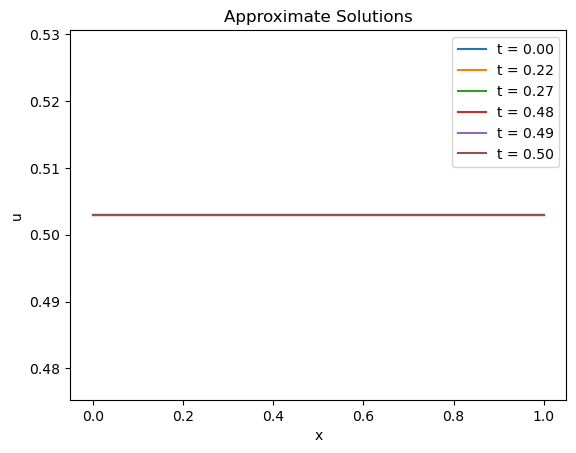

In [82]:
# Specify the time steps at which you want to plot
time_steps = [0.0,  0.22, 0.27,0.48,0.49, 0.5]

# Create a figure and axis
fig, ax = plt.subplots()

# Iterate through the specified time steps and plot the data
for t in time_steps:
    # Find the index corresponding to the closest time step in the prediction array
    tstep = int(t / dt)  # Assuming you have a time step size 'dt'

    # Plot the data at the current time step with label
    ax.plot(x_values, predictions[tstep*N:tstep*N+(N+1)].cpu().detach().numpy(), label=f't = {t:.2f}')

# Add labels, legend, and other plot details
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.set_title('Approximate Solutions')
ax.legend()

# Show the plot
plt.show()